<a href="https://colab.research.google.com/github/StanleyLiangYork/Advance_NN_techniques/blob/main/DCGAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.datasets import fashion_mnist

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image
import pandas as pd

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.12.0


In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
def true_label(x):
  label_dict = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot' }
  return label_dict[x]

In [14]:
# get only the T-shirt/top images
image_train = []
label_train = []
for i, label in enumerate(y_train):
  if label == 0:
    image_train.append(x_train[i])
    label_train.append(y_train[i])

image_train = np.array(image_train)
label_train = np.array(label_train)

In [15]:
image_test = []
label_test = []
for i, label in enumerate(y_test):
  if label == 1:
    image_test.append(x_test[i])
    label_test.append(y_test[i])

image_test = np.array(image_test)
label_test = np.array(label_test)

In [16]:
def preprocess(image, label):
  # scale from [0,255] to [-1,1]
  image = tf.expand_dims(image,axis=-1)
  image = tf.cast(image, dtype='float16')
  image = (image - 127.5) / 127.5
  # scaler = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
  return image

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
traind_ds = tf.data.Dataset.from_tensor_slices((image_train, label_train))
traind_dataset = traind_ds.map(preprocess, num_parallel_calls=AUTOTUNE).shuffle(1000).batch(batch_size).prefetch(1)

In [18]:
images= next(iter(traind_dataset))
images.shape

TensorShape([64, 28, 28, 1])

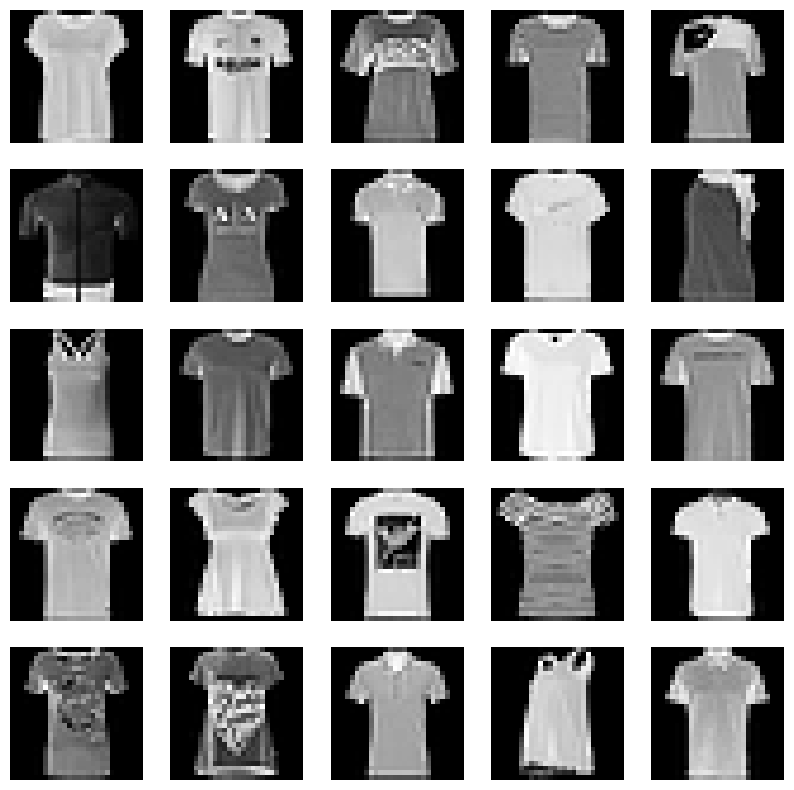

In [19]:
plt.figure(figsize=(10,10))
for i in range(5 * 5):
  plt.subplot(5, 5, 1 + i)
  plt.axis(False)
  load_image = images[i]
  show_image = tf.keras.preprocessing.image.array_to_img(load_image)
  # plt.title(true_label(labels[i].numpy()))
  plt.imshow(show_image,cmap='gray')
plt.show()

Define the discriminator

In [33]:
from keras.engine.training import optimizer
from keras.layers.serialization import activation
discriminator = Sequential([
    Conv2D(64, 5, strides=2, input_shape=[28, 28, 1], padding='same'),
    # (28-5)/2+1=12
    LeakyReLU(),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    Conv2D(128, 5, strides=2, padding='same'),
    LeakyReLU(),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    Conv2D(128, 5, strides=2, padding='same'),
    LeakyReLU(),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    Flatten(), # 1*1*256=256
    Dense(1),
    ])

optimizer_d = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
optimizer_g = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
# discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer_d, metrics=['accuracy'])
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_42 (Bat  (None, 14, 14, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                     

Define the generator

In [31]:
generator = Sequential([
    tf.keras.layers.Input((100,)),  # match the output of the discriminator
    Dense(4*4*128), # match the output of the discriminator
    Reshape((4,4,128)),
    # 1*1*256
    Conv2DTranspose(256, 5, activation='relu'), # (1-1)*1+5-2*0=5
    BatchNormalization(),
    # 5*5*256
    Conv2DTranspose(128, 5, activation='relu'), # (5-1)*1+5-2*0= 9
    BatchNormalization(),
    # 9*9*128
    Conv2DTranspose(128, 5, activation='relu'), # (9-1)*1+5-2*0= 13
    BatchNormalization(),
    # 13*13*128
    Conv2DTranspose(64, 5, activation='relu'), # (13-1)*1+5-2*0= 17
    BatchNormalization(),
    # 17*17*64
    Conv2DTranspose(64, 5, activation='relu'), # (13-1)*1+5-2*0= 21
    BatchNormalization(),
    # 21*21*64
    Conv2DTranspose(32, 5, activation='relu'), # (21-1)*1+4-2*0= 25
    BatchNormalization(),
    # 25*25*32
    Conv2DTranspose(16, 4, activation='relu'), # (25-1)*1+4-2*0= 28
    BatchNormalization(),
    # 28*28*16
    Conv2DTranspose(1, 1, activation='sigmoid'), # (28-1)*1+1-2*0= 28
    # 28*28*1
    ])
# we dont compile the generator because we compile it inside the GAN
# generator.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer_g, metrics=['accuracy'])
generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               25856     
                                                                 
 reshape (Reshape)           (None, 1, 1, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 5, 5, 256)        1638656   
 nspose)                                                         
                                                                 
 batch_normalization_33 (Bat  (None, 5, 5, 256)        1024      
 chNormalization)                                                
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 9, 9, 128)        819328    
 ranspose)                                                       
                                                     

1/1 [==============================] - 3s 3s/step


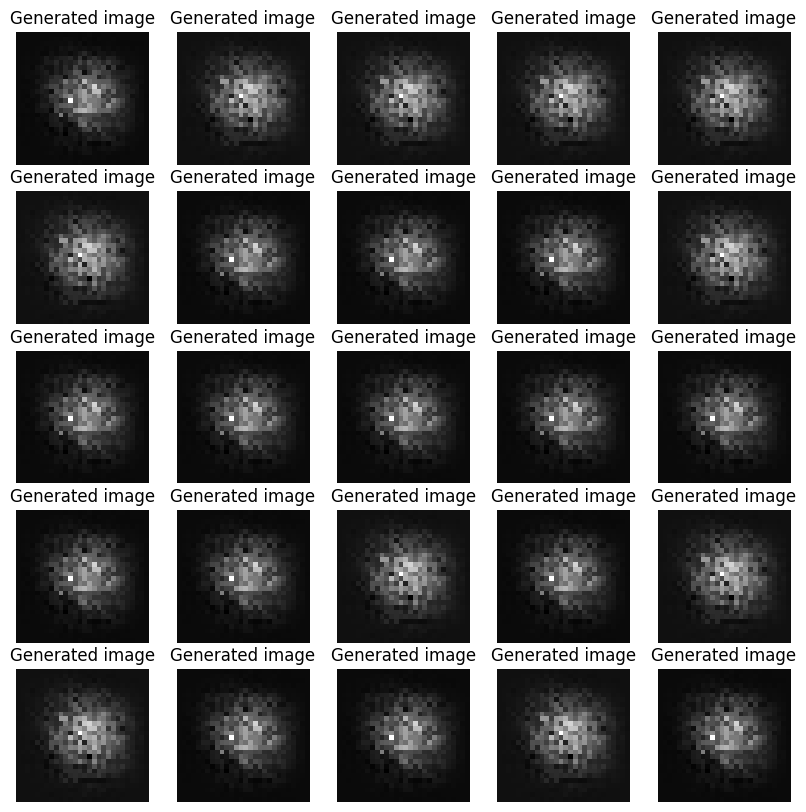

In [13]:
noise = tf.random.normal((25,1))
gen_image = generator.predict(noise)
gen_image.shape

plt.figure(figsize=(10,10))
for i in range(5 * 5):
  plt.subplot(5, 5, 1 + i)
  plt.axis(False)
  load_image = gen_image[i]
  show_image = tf.keras.preprocessing.image.array_to_img(load_image)
  plt.title('Generated image')
  plt.imshow(show_image,cmap='gray')
plt.show()

Define the GAN

In [14]:
inputs = tf.keras.layers.Input(shape=(1,))
gen_out = generator(inputs)
dis_out = discriminator(gen_out)
# input a noise, output a guest

In [15]:
gan = Model(inputs, dis_out)
# we embed the generator inside the discriminator
# when we optimize the discriminator, we simutaneously optimize the generator
discriminator.trainable = False

In [16]:
gan.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer_g, metrics=['accuracy'])

In [17]:
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         3237761   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1027073   
                                                                 
Total params: 4,264,834
Trainable params: 3,236,385
Non-trainable params: 1,028,449
_________________________________________________________________


Optimize the GAN

In [18]:
def plot_image(image, epoch_num):
  plt.figure(figsize=(5,5))
  plt.axis(False)
  load_image = image[0,:,:,:]
  show_image = tf.keras.preprocessing.image.array_to_img(load_image)
  plt.title(f'image at epoch {epoch_num+1}')
  plt.imshow(show_image,cmap='gray')
  plt.show()

In [19]:
criterion = tf.keras.losses.BinaryCrossentropy()

Define a manual train step -- more control to the training details

In [20]:
def train_step(real__images):
  batch_size = real__images.shape[0]
  true_examples = real__images
  noise = tf.random.normal((batch_size,1))
  gen_examples = generator.predict(noise, verbose=False)
  x_batch = tf.concat([gen_examples, true_examples], axis=0)
  y_batch = tf.concat([tf.zeros_like(labels, dtype='float16'), tf.ones(shape=(batch_size), dtype='float16')], axis=0) # gen_image=0, real_image=1
  # shuffle the examples with the label, cannot use np.shuffle because the examples should match their labels
  idx = np.random.choice(range(batch_size*2), batch_size*2,replace=False)
  x_batch = tf.gather(x_batch, indices=idx)
  y_batch = tf.gather(y_batch, indices=idx)

  # train the discriminator
  discriminator.trainable = True
  with tf.GradientTape(persistent=True) as tape:
    pred_y = discriminator(x_batch, training=True)
    disc_loss = criterion(pred_y, y_batch) / 2
  disc_grads = tape.gradient(disc_loss, discriminator.trainable_variables)
  optimizer_d.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
  pred_binary = np.where((pred_y).numpy() >= 0.5, 1, 0)
  accuracy = np.sum(np.logical_and(pred_y.numpy(), pred_binary))/ pred_y.shape[0]
  # lock the discriminator weights to train the generator alone
  discriminator.trainable = False

  # train the generator
  with tf.GradientTape(persistent=True) as tape:
    gan_out = gan(noise, training=True)
    gen_loss = criterion(gan_out, tf.ones(shape=(batch_size)))
  gen_grads = tape.gradient(gen_loss, generator.trainable_variables)
  optimizer_g.apply_gradients(zip(gen_grads, generator.trainable_variables))
  return gen_loss, accuracy

Complied version of training loop

1/1 [==============================] - 0s 139ms/step


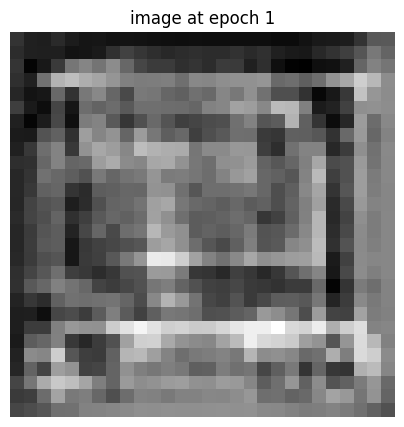

epoch: 1 ==== Disc Acc: 0.85 ==== GAN Loss: 0.51 ==== time: 26.302565336227417
1/1 [==============================] - 0s 22ms/step


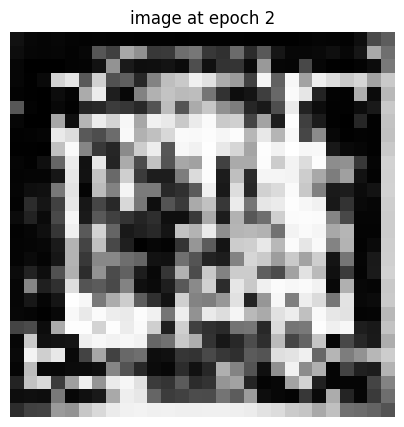

epoch: 2 ==== Disc Acc: 0.52 ==== GAN Loss: 0.57 ==== time: 13.648401975631714
1/1 [==============================] - 0s 22ms/step


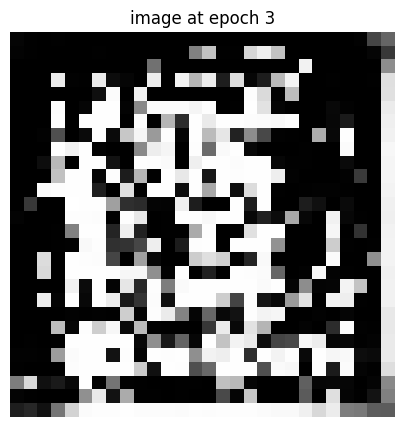

epoch: 3 ==== Disc Acc: 0.89 ==== GAN Loss: 2.87 ==== time: 13.832278966903687
1/1 [==============================] - 0s 21ms/step


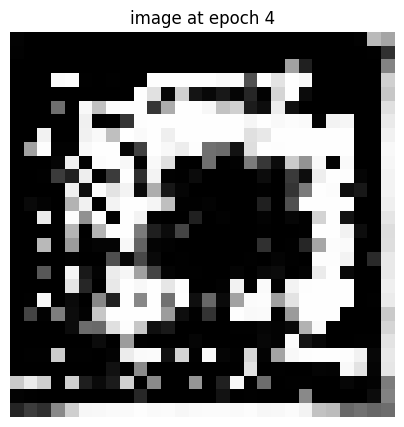

epoch: 4 ==== Disc Acc: 0.99 ==== GAN Loss: 5.34 ==== time: 13.75934386253357
1/1 [==============================] - 0s 23ms/step


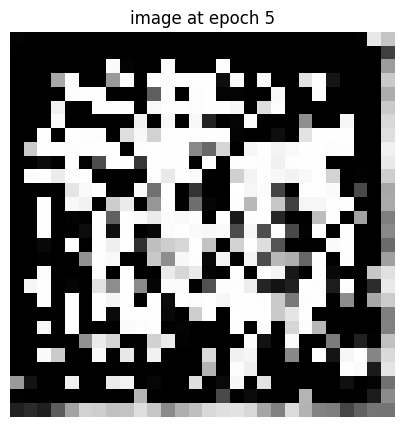

epoch: 5 ==== Disc Acc: 1.0 ==== GAN Loss: 6.86 ==== time: 13.629658699035645
1/1 [==============================] - 0s 22ms/step


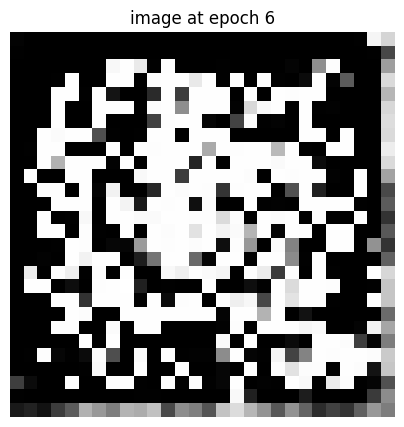

epoch: 6 ==== Disc Acc: 1.0 ==== GAN Loss: 8.1 ==== time: 14.243263244628906
1/1 [==============================] - 0s 21ms/step


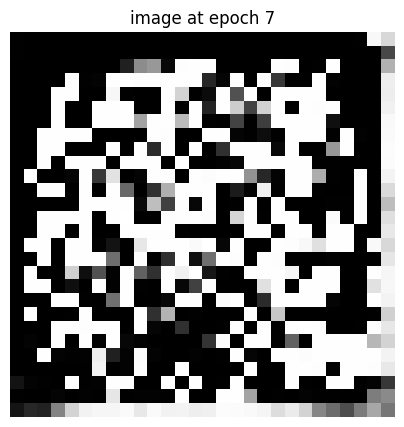

epoch: 7 ==== Disc Acc: 1.0 ==== GAN Loss: 9.72 ==== time: 13.693796157836914
1/1 [==============================] - 0s 22ms/step


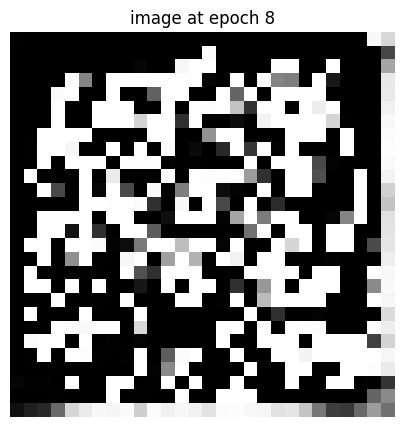

epoch: 8 ==== Disc Acc: 1.0 ==== GAN Loss: 9.96 ==== time: 13.765254497528076
1/1 [==============================] - 0s 20ms/step


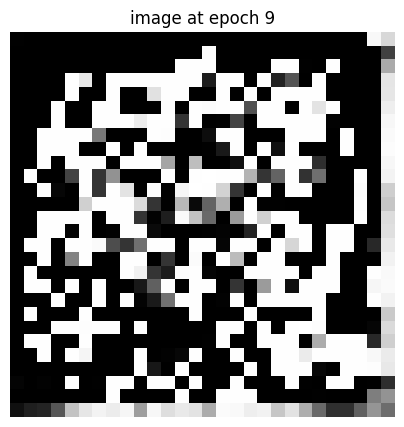

epoch: 9 ==== Disc Acc: 1.0 ==== GAN Loss: 10.75 ==== time: 13.565425395965576
1/1 [==============================] - 0s 22ms/step


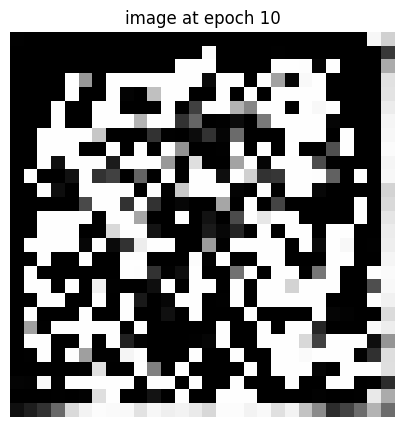

epoch: 10 ==== Disc Acc: 1.0 ==== GAN Loss: 10.85 ==== time: 13.59498643875122
1/1 [==============================] - 0s 23ms/step


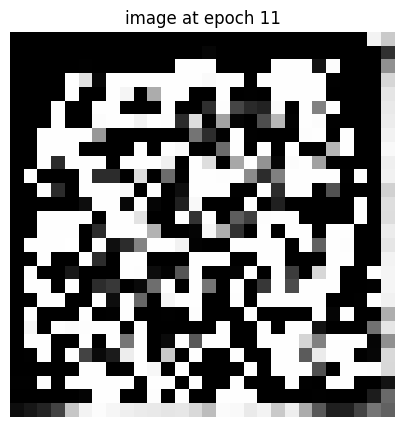

epoch: 11 ==== Disc Acc: 1.0 ==== GAN Loss: 11.16 ==== time: 14.44567060470581
1/1 [==============================] - 0s 22ms/step


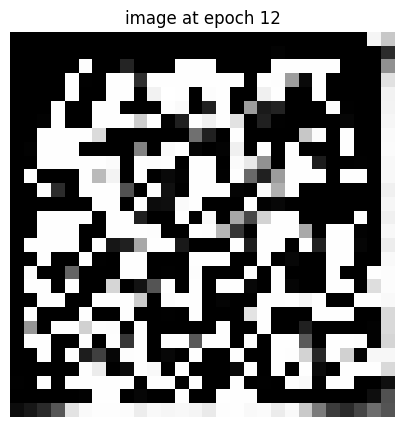

epoch: 12 ==== Disc Acc: 1.0 ==== GAN Loss: 10.74 ==== time: 13.95550799369812
1/1 [==============================] - 0s 21ms/step


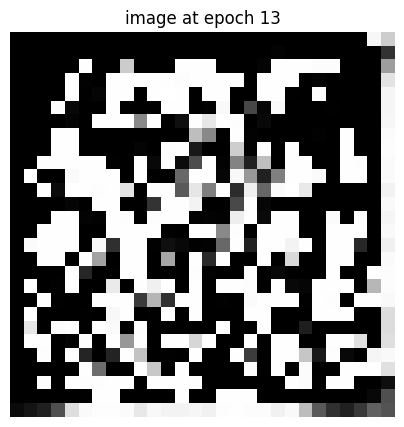

epoch: 13 ==== Disc Acc: 1.0 ==== GAN Loss: 11.12 ==== time: 13.923888444900513
1/1 [==============================] - 0s 22ms/step


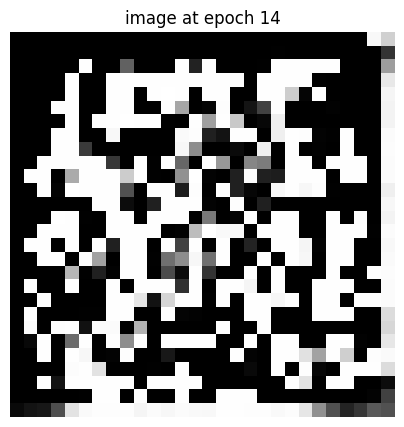

epoch: 14 ==== Disc Acc: 1.0 ==== GAN Loss: 10.76 ==== time: 13.865064859390259
1/1 [==============================] - 0s 20ms/step


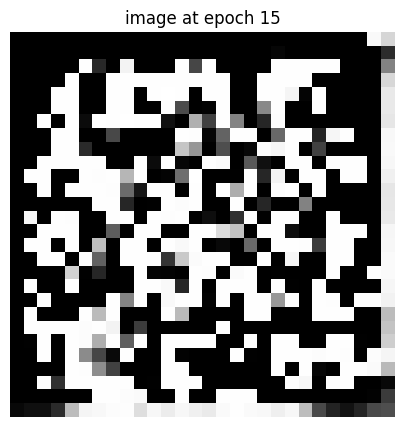

epoch: 15 ==== Disc Acc: 1.0 ==== GAN Loss: 11.02 ==== time: 13.467634916305542
1/1 [==============================] - 0s 20ms/step


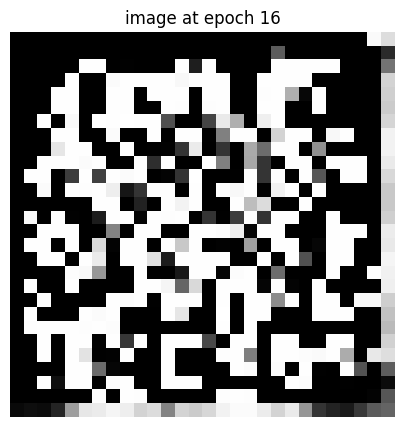

epoch: 16 ==== Disc Acc: 1.0 ==== GAN Loss: 11.73 ==== time: 13.818589925765991
1/1 [==============================] - 0s 20ms/step


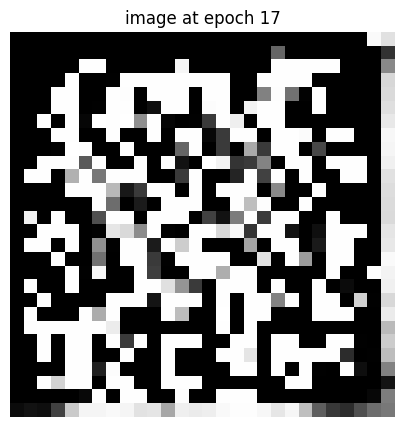

epoch: 17 ==== Disc Acc: 1.0 ==== GAN Loss: 11.81 ==== time: 13.128165245056152
1/1 [==============================] - 0s 20ms/step


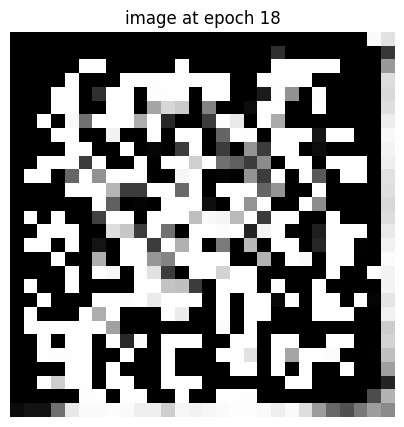

epoch: 18 ==== Disc Acc: 1.0 ==== GAN Loss: 12.39 ==== time: 13.102385759353638
1/1 [==============================] - 0s 21ms/step


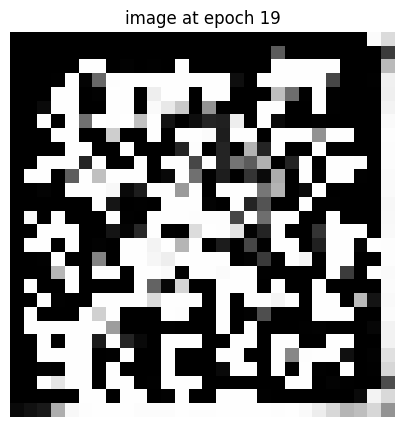

epoch: 19 ==== Disc Acc: 1.0 ==== GAN Loss: 12.24 ==== time: 13.157971858978271
1/1 [==============================] - 0s 20ms/step


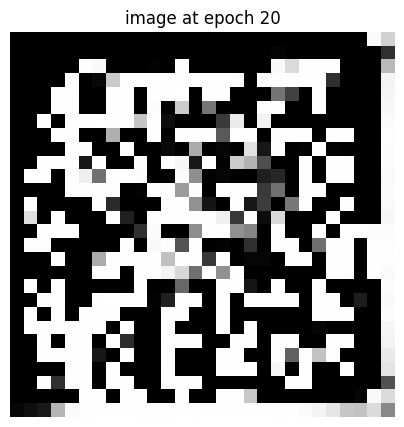

epoch: 20 ==== Disc Acc: 1.0 ==== GAN Loss: 11.63 ==== time: 13.18617558479309
1/1 [==============================] - 0s 21ms/step


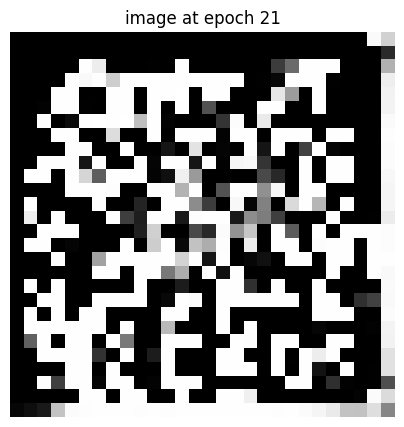

epoch: 21 ==== Disc Acc: 1.0 ==== GAN Loss: 12.14 ==== time: 13.799241304397583
1/1 [==============================] - 0s 20ms/step


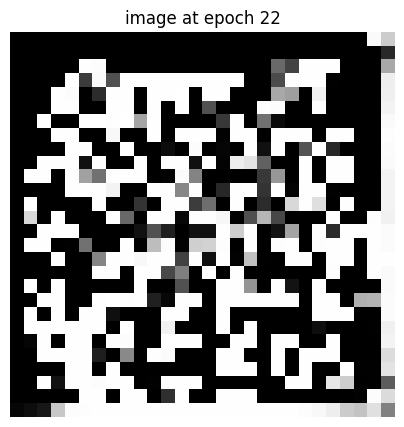

epoch: 22 ==== Disc Acc: 1.0 ==== GAN Loss: 12.57 ==== time: 13.136534929275513
1/1 [==============================] - 0s 20ms/step


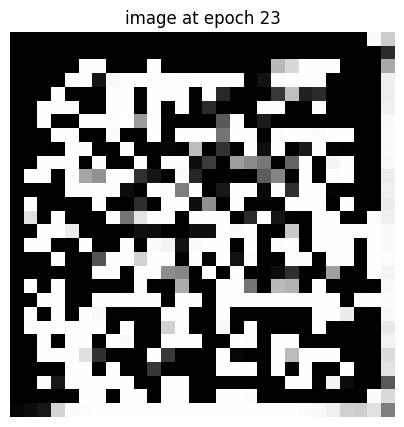

epoch: 23 ==== Disc Acc: 1.0 ==== GAN Loss: 12.29 ==== time: 13.159971237182617
1/1 [==============================] - 0s 20ms/step


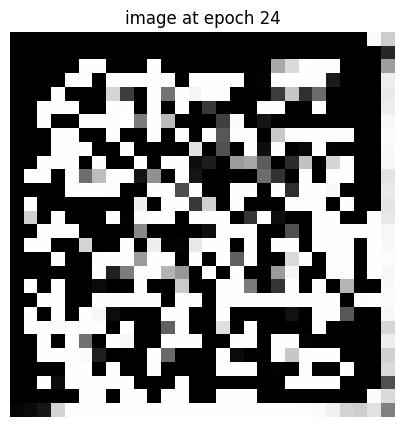

epoch: 24 ==== Disc Acc: 1.0 ==== GAN Loss: 12.58 ==== time: 13.133466958999634
1/1 [==============================] - 0s 21ms/step


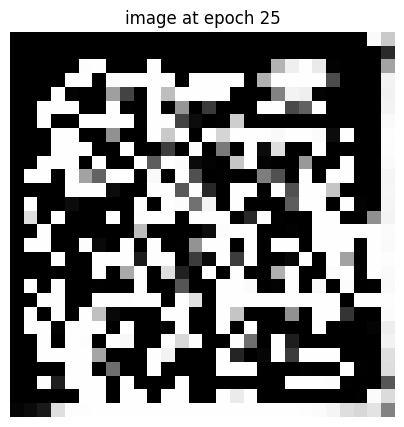

epoch: 25 ==== Disc Acc: 1.0 ==== GAN Loss: 12.49 ==== time: 13.135544300079346
1/1 [==============================] - 0s 20ms/step


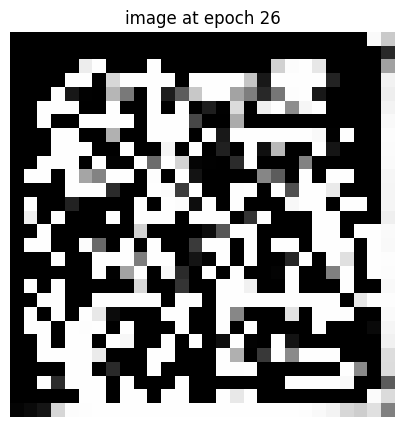

epoch: 26 ==== Disc Acc: 1.0 ==== GAN Loss: 12.37 ==== time: 14.288474082946777
1/1 [==============================] - 0s 21ms/step


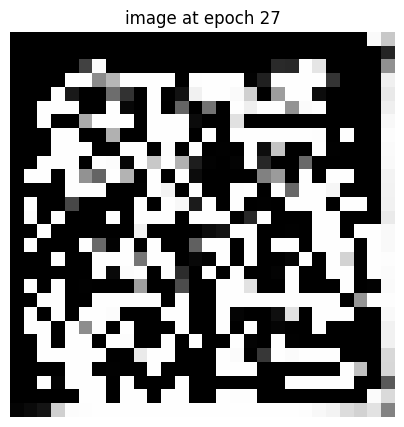

epoch: 27 ==== Disc Acc: 1.0 ==== GAN Loss: 12.76 ==== time: 13.285516738891602
1/1 [==============================] - 0s 21ms/step


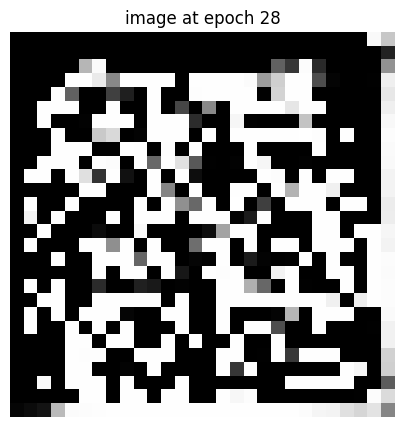

epoch: 28 ==== Disc Acc: 1.0 ==== GAN Loss: 12.82 ==== time: 13.460182905197144
1/1 [==============================] - 0s 21ms/step


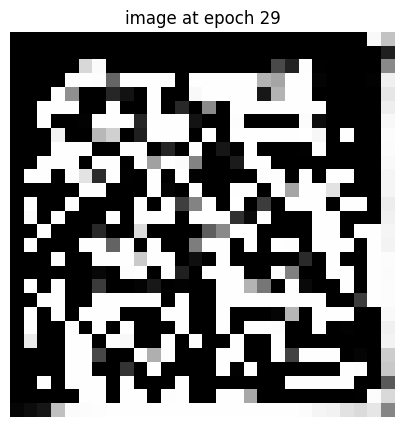

epoch: 29 ==== Disc Acc: 1.0 ==== GAN Loss: 12.92 ==== time: 13.519300937652588
1/1 [==============================] - 0s 21ms/step


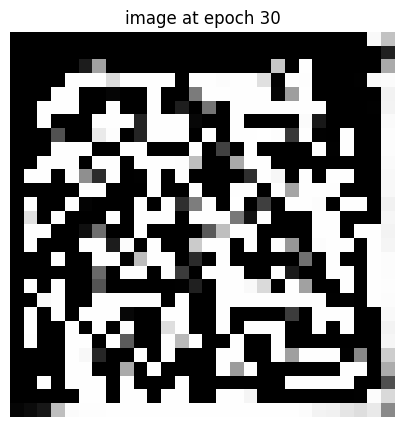

epoch: 30 ==== Disc Acc: 1.0 ==== GAN Loss: 13.22 ==== time: 13.766311883926392


In [21]:
import time
epochs = 30
history = {}
history['loss'] = []
history['disc_acc'] = []

for epoch in range(epochs):
  loss_list = []
  acc_list = []
  start = time.time()
  for images, labels in traind_dataset:
    batch_size = labels.shape[0]
    true_examples = images
    noise = tf.random.normal((batch_size,1)) # the # of examples in the last batch can be different
    gen_examples = generator.predict(noise, verbose=False)
    # make a train batch
    x_batch = tf.concat([gen_examples, true_examples], axis=0)
    y_batch = tf.concat([tf.zeros_like(labels, dtype='float16'), tf.ones(shape=(batch_size), dtype='float16')], axis=0)
    # shuffle the examples with the label, cannot use np.shuffle because the examples should match their labels
    idx = np.random.choice(range(batch_size*2), batch_size*2,replace=False)
    x_batch = tf.gather(x_batch, indices=idx)
    y_batch = tf.gather(y_batch, indices=idx)

    # train the discriminator
    discriminator.trainable = True
    discriminator.train_on_batch(x_batch, y_batch)
    # lock the discriminator to train the generator
    # accuracy has no meaning for the generator
    # the labels should be all ones because we let the GAN treats all generated images are real
    discriminator.trainable = False
    loss_1, _ = gan.train_on_batch(noise, tf.ones(shape=(batch_size)))
    # loss_2, _ = gan.train_on_batch(noise, tf.ones(shape=(batch_size)))
    # loss = (loss_1+loss_2)/2
    loss = loss_1
    loss_list.append(loss)
    _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)
    acc_list.append(acc)

  end_time = time.time()
  noise_show = tf.random.normal((1,1))
  gen_image = generator.predict(noise_show)
  plot_image(image=gen_image, epoch_num=epoch)
  loss = np.mean(np.array(loss_list))
  history['loss'].append(loss)
  acc = np.mean(np.array(acc_list))
  history['disc_acc'].append(acc)
  print(f'epoch: {epoch+1} ==== Disc Acc: {round(acc,2)} ==== GAN Loss: {round(loss,2)} ==== time: {end_time - start}')
